In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\Joaquín Amat\\Documents\\GitHub\\skforecast'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# set theme for matplotlib
plt.style.use('seaborn-v0_8-darkgrid')

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression   
from sklearn.ensemble import RandomForestRegressor
from lineartree import LinearForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from skforecast.preprocessing import TimeSeriesDifferentiator
from skforecast.model_selection import backtesting_forecaster

# Data

Train dates : 1991-07-01 00:00:00 --- 2003-03-01 00:00:00  (n=141)
Test dates  : 2003-04-01 00:00:00 --- 2008-06-01 00:00:00  (n=63)


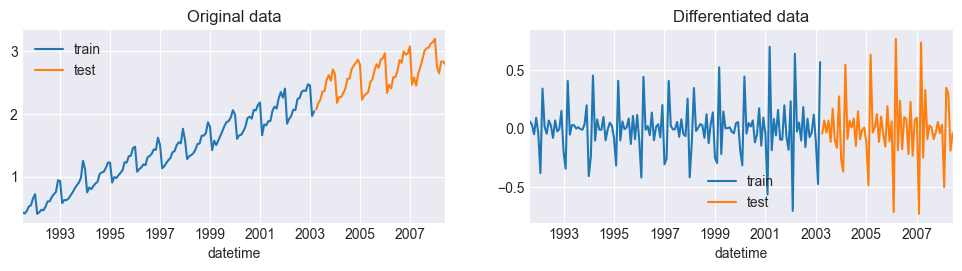

In [3]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o.csv'
)
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Add a smooth positive trend
# ==============================================================================
t = np.arange(len(data))
data = data + 0.01 * t

# Data differentiated
# ==============================================================================
diferenciator_1 = TimeSeriesDifferentiator(order=1)
diferenciator_2 = TimeSeriesDifferentiator(order=2)
data_diff_1 = diferenciator_1.fit_transform(data)
data_diff_1 = pd.Series(data_diff_1, index=data.index).dropna()
data_diff_2 = diferenciator_2.fit_transform(data)
data_diff_2 = pd.Series(data_diff_2, index=data.index).dropna()

# Simulated exogenous variable
# ==============================================================================
rng = np.random.default_rng(9876)
exog = pd.Series(
    rng.normal(loc=0, scale=1, size=len(data)), index=data.index, name='exog'
)
exog_diff_1 = exog.iloc[1:]
exog_diff_2 = exog.iloc[2:]

# Data partition train-test
# ==============================================================================
end_train = '2003-03-01 23:59:00'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, axs = plt.subplots(1, 2, figsize=(12, 2.5))
axs = axs.ravel()
data.loc[:end_train].plot(ax=axs[0], label='train')
data.loc[end_train:].plot(ax=axs[0], label='test')
axs[0].legend()
axs[0].set_title('Original data')

data_diff_2.loc[:end_train].plot(ax=axs[1], label='train')
data_diff_2.loc[end_train:].plot(ax=axs[1], label='test')
axs[1].legend()
axs[1].set_title('Differentiated data');

# Compare regressors

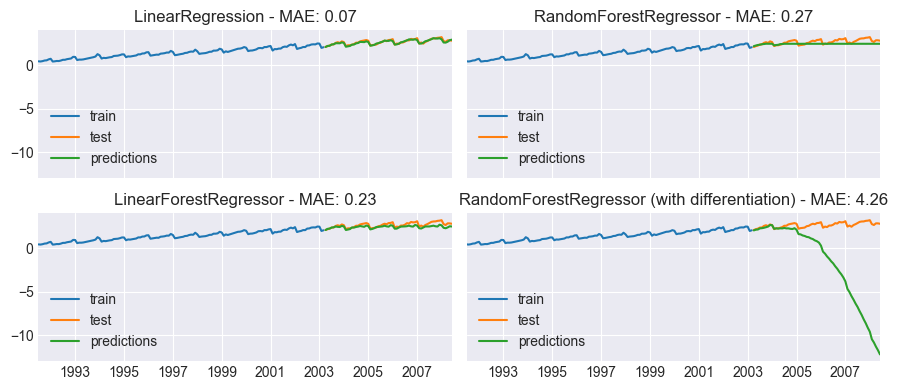

In [4]:
# Compare predictions of different models
# ==============================================================================
regressors = [
    LinearRegression(),
    RandomForestRegressor(random_state=963),
    LinearForestRegressor(base_estimator=LinearRegression(), max_features='sqrt')
]
steps = len(data.loc[end_train:])

fig, ax = plt.subplots(2, 2, figsize=(9, 4), sharex=True, sharey=True)
ax = ax.ravel()
# ForecasterAutoreg
for i, regressor in enumerate(regressors):
    forecaster = ForecasterAutoreg(
        regressor=regressor,
        lags=15
    )
    forecaster.fit(y=data.loc[:end_train], exog=exog.loc[:end_train])
    predictions = forecaster.predict(steps=steps, exog=exog.loc[end_train:])
    error = mean_absolute_error(data.loc[end_train:], predictions)
    data.loc[:end_train].plot(ax=ax[i], label='train')
    data.loc[end_train:].plot(ax=ax[i], label='test')
    predictions.plot(ax=ax[i], label='predictions')
    ax[i].set_title(
        f'{forecaster.regressor.__class__.__name__} - MAE: {error:.2f}',
        size=12
    )
    ax[i].set_xlabel('')
    ax[i].legend()

# ForecasterAutoreg with random forest regressor and differentiation
forecaster = ForecasterAutoreg(
                 regressor       = RandomForestRegressor(random_state=963),
                 lags            = 15,
                 differentiation = 2
            )
forecaster.fit(y=data.loc[:end_train], exog=exog.loc[:end_train])
predictions = forecaster.predict(steps=steps, exog=exog.loc[end_train:])
error = mean_absolute_error(data.loc[end_train:], predictions)
data.loc[:end_train].plot(ax=ax[3], label='train')
data.loc[end_train:].plot(ax=ax[3], label='test')
predictions.plot(ax=ax[3], label='predictions')
ax[3].set_title(
        f'{forecaster.regressor.__class__.__name__} (with differentiation) - MAE: {error:.2f}',
        size=12
    )
ax[3].set_xlabel('')
ax[3].legend()

fig.tight_layout()

# Validation: differentiation before training or during the training

## Predict

Series differentiated before training
-------------------------------------
Last window of training series: datetime
2002-01-01    0.230831
2002-02-01   -0.703838
2002-03-01    0.635863
2002-04-01   -0.026883
2002-05-01    0.049379
2002-06-01   -0.103919
2002-07-01    0.181810
2002-08-01   -0.159664
2002-09-01    0.082526
2002-10-01   -0.075052
2002-11-01   -0.033959
2002-12-01    0.116160
2003-01-01   -0.120611
2003-02-01   -0.475218
2003-03-01    0.564886
Freq: MS, dtype: float64
Train matrix


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,exog
datetime,,,,,,,,,,,,,,,,
1992-12-01,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,0.029131,0.060142,0.082714
1993-01-01,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,0.029131,1.397494
1993-02-01,-0.195789,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,-1.378728


Predictions


2003-04-01     2.031051
2003-05-01     2.115779
2003-06-01     2.132869
2003-07-01     2.261443
2003-08-01     2.284158
                ...    
2008-02-01   -10.427021
2008-03-01   -10.797169
2008-04-01   -11.273722
2008-05-01   -11.687452
2008-06-01   -12.167940
Length: 63, dtype: float64


Series differentiated during training
-------------------------------------
Last window of training series: datetime
2001-11-01    2.349590
2001-12-01    2.262313
2002-01-01    2.405868
2002-02-01    1.845584
2002-03-01    1.921165
2002-04-01    1.969862
2002-05-01    2.067938
2002-06-01    2.062096
2002-07-01    2.238064
2002-08-01    2.254368
2002-09-01    2.353198
2002-10-01    2.376976
2002-11-01    2.366796
2002-12-01    2.472776
2003-01-01    2.458145
2003-02-01    1.968296
2003-03-01    2.043333
Freq: MS, Name: y, dtype: float64
Train matrix


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,exog
datetime,,,,,,,,,,,,,,,,
1992-12-01,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,0.029131,0.060142,0.082714
1993-01-01,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,0.029131,1.397494
1993-02-01,-0.195789,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,-1.378728


Predictions


2003-04-01     2.031051
2003-05-01     2.115779
2003-06-01     2.132869
2003-07-01     2.261443
2003-08-01     2.284158
                ...    
2008-02-01   -10.427021
2008-03-01   -10.797169
2008-04-01   -11.273722
2008-05-01   -11.687452
2008-06-01   -12.167940
Freq: MS, Name: pred, Length: 63, dtype: float64

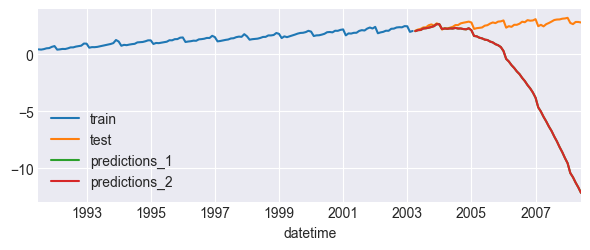

In [5]:
# Comparasion of results if the time series is differentiated before training or during the training
# =================================================================================================
print("Series differentiated before training")
print("-------------------------------------")
steps = len(data.loc[end_train:])
forecaster_1 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15
             )
forecaster_1.fit(y=data_diff_2.loc[:end_train], exog=exog_diff_2.loc[:end_train])
last_window_1 = forecaster_1.last_window
print(f"Last window of training series: {last_window_1}")
print("Train matrix")
X_train_1, y_train_1 = forecaster_1.create_train_X_y(
                            data_diff_2.loc[:end_train],
                            exog=exog_diff_2.loc[:end_train]
                       )
display(X_train_1.head(3))
predictions_diff_2 = forecaster_1.predict(steps=steps, exog=exog_diff_2.loc[end_train:])
last_value_train_diff = data_diff_1.loc[:end_train].iloc[[-1]]
predictions_diff_1 = pd.concat([last_value_train_diff, predictions_diff_2]).cumsum()[1:]
last_value_train = data.loc[:end_train].iloc[[-1]]
predictions_1 = pd.concat([last_value_train, predictions_diff_1]).cumsum()[1:]
print("Predictions")
display(predictions_1)
print("")

print("Series differentiated during training")
print("-------------------------------------")
forecaster_2 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15,
                 differentiation = 2
             )
forecaster_2.fit(y=data.loc[:end_train], exog=exog.loc[:end_train])
last_window_2 = forecaster_2.last_window
print(f"Last window of training series: {last_window_2}")
print("Train matrix")
X_train_2, y_train_2 = forecaster_2.create_train_X_y(
                            data.loc[:end_train],
                            exog=exog.loc[:end_train]
                        )
display(X_train_2.head(3))
predictions_2 = forecaster_2.predict(steps=steps, exog=exog.loc[end_train:])
print("Predictions")
display(predictions_2)

fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_1.plot(ax=ax, label='predictions_1')
predictions_2.plot(ax=ax, label='predictions_2')
ax.legend();

In [6]:
pd.testing.assert_frame_equal(X_train_1, X_train_2, check_names=True)
pd.testing.assert_frame_equal(forecaster_1.get_feature_importances(), forecaster_2.get_feature_importances(), check_names=True)
pd.testing.assert_series_equal(predictions_1.asfreq('MS'), predictions_2, check_names=False)

c:\anaconda\envs\skforecast_10_py11\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


2003-04-01    2.117415
2003-05-01    2.186097
2003-06-01    2.221086
2003-07-01    2.359641
Freq: MS, Name: predicted_mean, dtype: float64

2003-04-01    2.118218
2003-05-01    2.191517
2003-06-01    2.222458
2003-07-01    2.367209
Freq: MS, Name: pred, dtype: float64

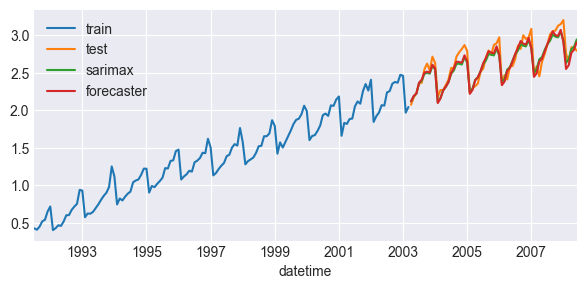

In [8]:
# Compare predictions with an arima (lags, 1, 0)
# ==============================================================================
from statsmodels.tsa.statespace.sarimax import SARIMAX
steps = len(data.loc[end_train:])

sarimax = SARIMAX(data.loc[:end_train], order=(12, 2, 0))
res_sarimax = sarimax.fit(disp=False, maxiter=1000)
predictions_sarimax = res_sarimax.get_forecast(steps).predicted_mean
display(predictions_sarimax.head(4))

forecaster = ForecasterAutoreg(
                 regressor       = LinearRegression(),
                 lags            = 12,
                 differentiation = 2
            )
            
forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=steps)
display(predictions.head(4))

fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_sarimax.plot(ax=ax, label='sarimax')
predictions.plot(ax=ax, label='forecaster')
ax.legend();